# 1a

In [1]:
import pandas as pd

df = pd.read_csv('soccer17.csv')
df.head()

,Div,Date,Y,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,pH,pD,pA
0,EPL,2014-08-16,14,Arsenal,Crystal Palace,2,1,1,1,0.778038,0.151989,0.069973
1,EPL,2014-08-16,14,Leicester,Everton,2,2,1,2,0.311972,0.289820,0.398208
2,EPL,2014-08-16,14,Man United,Swansea,1,2,0,1,0.715373,0.192169,0.092459
3,EPL,2014-08-16,14,QPR,Hull,0,1,0,0,0.395113,0.300577,0.304311
4,EPL,2014-08-16,14,Stoke,Aston Villa,0,1,0,0,0.502378,0.282316,0.215305


In [2]:
df['game_id'] = df.index

In [3]:
df['Div'].unique()

array(['EPL', 'La_Liga', 'Bundesliga', 'Ligue_1', 'Serie_A'], dtype=object)

In [4]:
df.rename(columns={'FTHG': 'FTG_Home',
                   'FTAG': 'FTG_Away',
                   'HTHG': 'HTG_Home',
                   'HTAG': 'HTG_Away',
                   'HomeTeam': 'Team_Home',
                   'AwayTeam': 'Team_Away',
                   }, inplace=True)

In [5]:
df['goal_diff'] = df['FTG_Home'] - df['FTG_Away']

In [6]:
# 1 = win, -1 = loss, 0 = draw
df['Result_Home'] = (df['goal_diff'] > 0) + (df['goal_diff'] < 0) * (-1)
df['Result_Away'] = (df['goal_diff'] < 0) + (df['goal_diff'] > 0) * (-1)

In [7]:
df.head(10)

,Div,Date,Y,Team_Home,Team_Away,FTG_Home,FTG_Away,HTG_Home,HTG_Away,pH,pD,pA,game_id,goal_diff,Result_Home,Result_Away
0,EPL,2014-08-16,14,Arsenal,Crystal Palace,2,1,1,1,0.778038,0.151989,0.069973,0,1,1,-1
1,EPL,2014-08-16,14,Leicester,Everton,2,2,1,2,0.311972,0.289820,0.398208,1,0,0,0
2,EPL,2014-08-16,14,Man United,Swansea,1,2,0,1,0.715373,0.192169,0.092459,2,-1,-1,1
3,EPL,2014-08-16,14,QPR,Hull,0,1,0,0,0.395113,0.300577,0.304311,3,-1,-1,1
4,EPL,2014-08-16,14,Stoke,Aston Villa,0,1,0,0,0.502378,0.282316,0.215305,4,-1,-1,1
5,EPL,2014-08-16,14,West Brom,Sunderland,2,2,1,1,0.443622,0.293534,0.262843,5,0,0,0
6,EPL,2014-08-16,14,West Ham,Tottenham,0,1,0,0,0.247658,0.276261,0.476081,6,-1,-1,1
7,EPL,2014-08-17,14,Liverpool,Southampton,2,1,1,0,0.725996,0.178849,0.095155,7,1,1,-1
8,EPL,2014-08-17,14,Newcastle,Man City,0,2,0,1,0.169107,0.229163,0.601730,8,-2,-1,1
9,EPL,2014-08-18,14,Burnley,Chelsea,1,3,1,3,0.100399,0.203929,0.695672,9,-2,-1,1


In [8]:
df.shape

(7304, 16)

In [9]:
# surprisingly, the suffix doesn't work if it's `r'Home|Away'`. not sure why. `r'\D+'` works though
long_df = pd.wide_to_long(df,
                          stubnames=['Team', 'HTG', 'FTG', 'Result'],
                          i=['game_id'],
                          j='TeamType',
                          suffix=r'\D+',
                          sep='_').reset_index(drop=False)

In [10]:
# goal diff is from home team's perspective
long_df['goal_diff'] = long_df['goal_diff'] * (long_df['TeamType'] == 'Home').map({False: -1, True: 1})

In [11]:
long_df[long_df['game_id'] == 1139]

,game_id,TeamType,Div,pA,pD,goal_diff,Y,pH,Date,Team,HTG,FTG,Result
1139,1139,Home,EPL,0.143213,0.215606,1,17,0.641181,2017-08-11,Arsenal,2,4,1
8443,1139,Away,EPL,0.143213,0.215606,-1,17,0.641181,2017-08-11,Leicester,2,3,-1


In [12]:
# filter for EPL 2017
div_filter = (long_df['Div'] == 'EPL') & (long_df['Y'] == 17)

In [13]:
def win_count(x): return (x == 1).sum()
def draw_count(x): return (x == 0).sum()
def loss_count(x): return (x == -1).sum()

table_1a = long_df[div_filter].groupby(['Team']).agg({'game_id': 'nunique',  # number of games
                                                      'goal_diff': 'mean',  # avg goal differential
                                                      'Result': [win_count,
                                                                 draw_count,
                                                                 loss_count],  # win/draw/loss count
                                                      })

In [14]:
table_1a.columns = ['game_count', 'avg_goal_diff', 'wins', 'draws', 'losses']
table_1a.sort_values(by='avg_goal_diff', ascending=False, inplace=True)
table_1a

,game_count,avg_goal_diff,wins,draws,losses
Team,,,,,
Man City,38,2.078947,32,4,2
Liverpool,38,1.210526,21,12,5
Man United,38,1.052632,25,6,7
Tottenham,38,1.000000,23,8,7
Chelsea,38,0.631579,21,7,10
Arsenal,38,0.605263,19,6,13
Burnley,38,-0.078947,14,12,12
Leicester,38,-0.105263,12,11,15
Newcastle,38,-0.210526,12,8,18


In [15]:
table_1a.to_latex('hw1_1a.tex')

In [16]:
with open('hw1_1a.md', 'w') as f:
    table_1a.to_markdown(f)

# 1b

In [17]:
long_df['Points'] = long_df['Result'].map({1: 3, 0: 1, -1: 0})
long_df.head()

,game_id,TeamType,Div,pA,pD,goal_diff,Y,pH,Date,Team,HTG,FTG,Result,Points
0,0,Home,EPL,0.069973,0.151989,1,14,0.778038,2014-08-16,Arsenal,1,2,1,3
1,1,Home,EPL,0.398208,0.289820,0,14,0.311972,2014-08-16,Leicester,1,2,0,1
2,2,Home,EPL,0.092459,0.192169,-1,14,0.715373,2014-08-16,Man United,0,1,-1,0
3,3,Home,EPL,0.304311,0.300577,-1,14,0.395113,2014-08-16,QPR,0,0,-1,0
4,4,Home,EPL,0.215305,0.282316,-1,14,0.502378,2014-08-16,Stoke,0,0,-1,0


In [18]:
table_1b = long_df[div_filter].groupby(['Team']).agg({'game_id': 'nunique',  # number of games
                                                      'goal_diff': 'mean',  # avg goal differential
                                                      'Result': [win_count,
                                                                 draw_count,
                                                                 loss_count],  # win/draw/loss count
                                                      'Points': 'sum',  # total points
                                                      })

In [19]:
table_1b.columns = ['game_count', 'avg_goal_diff', 'wins', 'draws', 'losses', 'total_points']
table_1b.sort_values(by='total_points', ascending=False, inplace=True)
table_1b

,game_count,avg_goal_diff,wins,draws,losses,total_points
Team,,,,,,
Man City,38,2.078947,32,4,2,100
Man United,38,1.052632,25,6,7,81
Tottenham,38,1.000000,23,8,7,77
Liverpool,38,1.210526,21,12,5,75
Chelsea,38,0.631579,21,7,10,70
Arsenal,38,0.605263,19,6,13,63
Burnley,38,-0.078947,14,12,12,54
Everton,38,-0.368421,13,10,15,49
Leicester,38,-0.105263,12,11,15,47


In [20]:
table_1b.to_latex('hw1_1b.tex')

In [21]:
with open('hw1_1b.md', 'w') as f:
    table_1b.to_markdown(f)

# 1c

In [22]:
table_1c = (long_df[long_df['Y'] == 17].groupby(['Div', 'Team'],
                                                as_index=False).agg({'game_id': 'nunique',  # same as above
                                                                     'goal_diff': 'mean',
                                                                     'Result': [win_count,
                                                                                draw_count,
                                                                                loss_count],
                                                                     'Points': 'sum',
                                                                     })
                                       .sort_values(by=('goal_diff', 'mean'), ascending=False))

table_1c.columns = ['Div', 'Team', 'game_count', 'avg_goal_diff', 'wins', 'draws', 'losses', 'total_points']

# source: https://stackoverflow.com/questions/43762744/pandas-dataframe-group-by-a-take-nlargest-by-b-output-c
table_1c = (table_1c.groupby('Div')  # for each division
                    .head(3)  # pick the 3 largest by avg goal diff
                              # head(3) works because already sorted by avg goal diff above
                    .sort_values(by=['Div', 'avg_goal_diff'],
                                 ascending=[True, False])  # sort asc by Div, desc by avg goal diff
                    )
table_1c

,Div,Team,game_count,avg_goal_diff,wins,draws,losses,total_points
1,Bundesliga,Bayern Munich,34,1.882353,27,3,4,84
9,Bundesliga,Hoffenheim,34,0.529412,15,10,9,55
2,Bundesliga,Dortmund,34,0.500000,15,10,9,55
28,EPL,Man City,38,2.078947,32,4,2,100
27,EPL,Liverpool,38,1.210526,21,12,5,75
29,EPL,Man United,38,1.052632,25,6,7,81
41,La_Liga,Barcelona,38,1.842105,28,9,1,93
53,La_Liga,Real Madrid,38,1.315789,22,10,6,76
40,La_Liga,Ath Madrid,38,0.947368,23,10,5,79
72,Ligue_1,Paris SG,38,2.078947,29,6,3,93


In [23]:
table_1c.to_latex('hw1_1c.tex')

In [24]:
with open('hw1_1c.md', 'w') as f:
    table_1c.to_markdown(f)

# 2

In [25]:
df = pd.read_csv('soccer17.csv')
df.head()

,Div,Date,Y,HomeTeam,AwayTeam,FTHG,FTAG,HTHG,HTAG,pH,pD,pA
0,EPL,2014-08-16,14,Arsenal,Crystal Palace,2,1,1,1,0.778038,0.151989,0.069973
1,EPL,2014-08-16,14,Leicester,Everton,2,2,1,2,0.311972,0.289820,0.398208
2,EPL,2014-08-16,14,Man United,Swansea,1,2,0,1,0.715373,0.192169,0.092459
3,EPL,2014-08-16,14,QPR,Hull,0,1,0,0,0.395113,0.300577,0.304311
4,EPL,2014-08-16,14,Stoke,Aston Villa,0,1,0,0,0.502378,0.282316,0.215305


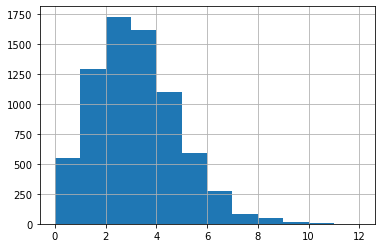

In [26]:
%matplotlib inline

df['total_goals'] = df['FTHG'] + df['FTAG']
df['total_goals'].hist(bins=12)

In [27]:
# poisson distribution
poisson_lambda = df['total_goals'].mean()

In [28]:
poisson_lambda

2.710158817086528

In [29]:
from scipy.stats import poisson

In [30]:
distrib_poisson = poisson(mu=poisson_lambda)

<StemContainer object of 3 artists>

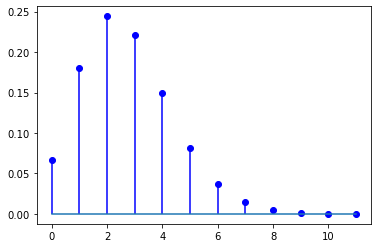

In [31]:
import matplotlib.pyplot as plt

plt.stem(range(12),
         distrib_poisson.pmf(range(12)),
         linefmt='b-',
         markerfmt='bo',
         basefmt='',
         use_line_collection=True)

<StemContainer object of 3 artists>

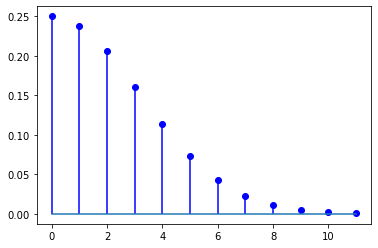

In [32]:
# folded normal (mu=0; i.e. half-normal)
from scipy.stats import halfnorm
import numpy as np

# from wikipedia's page on half normal
sigma_hat = np.sqrt((df['total_goals'] ** 2).mean())

distrib = halfnorm(scale=sigma_hat)
plt.stem(range(12), distrib.pdf(range(12)), linefmt='b-', markerfmt='bo', basefmt='', use_line_collection=True)

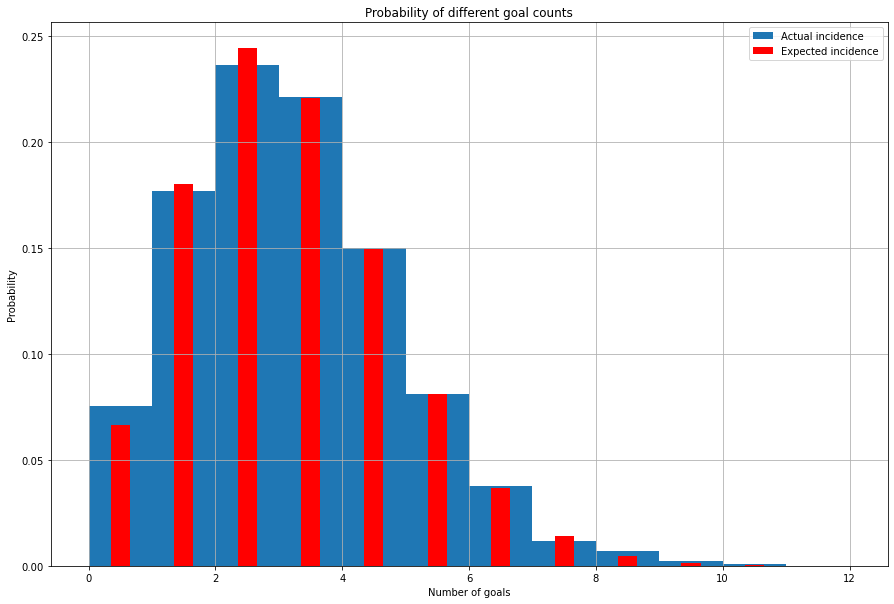

In [33]:
# this looks more like the histogram we got above. for the requested graph:

plt.figure(figsize=(15, 10))

df['total_goals'].hist(density=True, bins=12, label='Actual incidence')
# x slightly off to center the bar
plt.bar([x + 0.5 for x in range(12)],
        distrib_poisson.pmf(range(12)),
        color='r',
        width=0.3,
        label='Expected incidence')
plt.legend(loc='best')
plt.xlabel('Number of goals')
plt.ylabel('Probability')
plt.title('Probability of different goal counts')
plt.savefig('hw1_2a.png');

# 2b

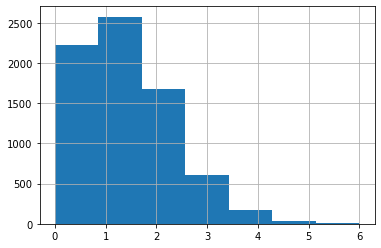

In [34]:
df['ht_goals'] = df['HTHG'] + df['HTAG']
df['ht_goals'].hist(bins=df['ht_goals'].nunique())

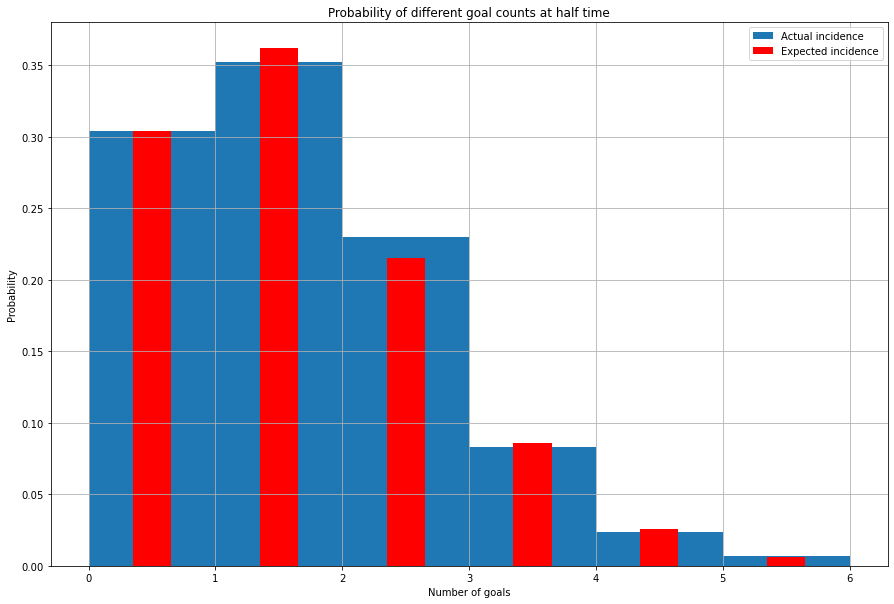

In [35]:
ht_lambda = df['ht_goals'].mean()
ht_distrib_poisson = poisson(mu=ht_lambda)

plt.figure(figsize=(15, 10))

df['ht_goals'].hist(density=True, bins=6, label='Actual incidence')
# x slightly off to center the bar
plt.bar([x + 0.5 for x in range(6)],
        ht_distrib_poisson.pmf(range(6)),
        color='r',
        width=0.3,
        label='Expected incidence')
plt.legend(loc='best')
plt.xlabel('Number of goals')
plt.ylabel('Probability')
plt.title('Probability of different goal counts at half time')
plt.savefig('hw1_2b.png');

In [36]:
ht_lambda

1.1907174151150055

# 2c

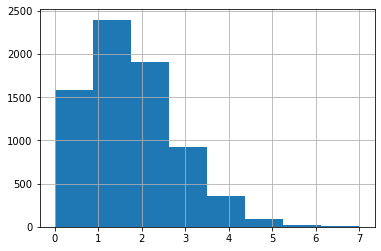

In [37]:
df['second_half_goals'] = df['total_goals'] - df['ht_goals']
df['second_half_goals'].hist(bins=df['second_half_goals'].nunique())

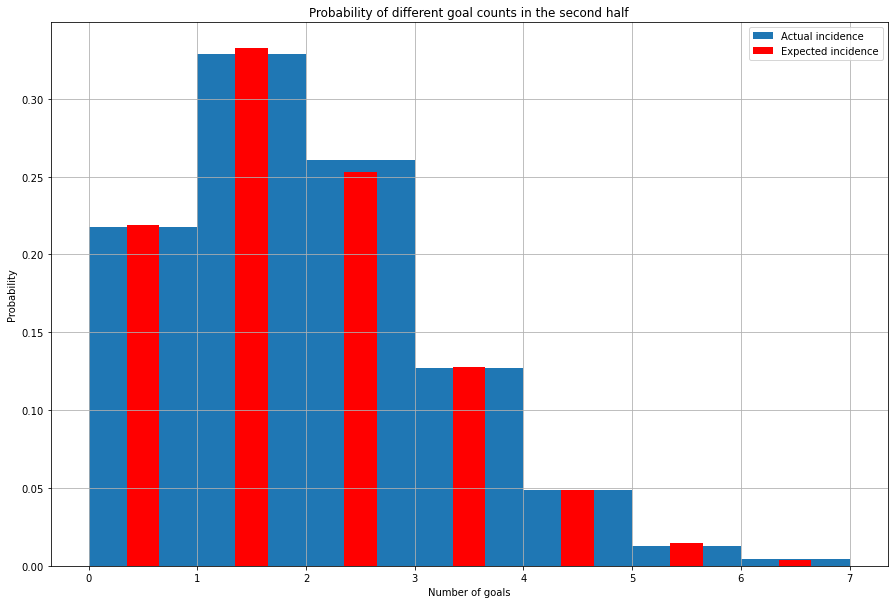

In [38]:
second_half_lambda = df['second_half_goals'].mean()
second_half_distrib_poisson = poisson(mu=second_half_lambda)

plt.figure(figsize=(15, 10))

df['second_half_goals'].hist(density=True, bins=7, label='Actual incidence')
# x slightly off to center the bar
plt.bar([x + 0.5 for x in range(7)],
        second_half_distrib_poisson.pmf(range(7)),
        color='r',
        width=0.3,
        label='Expected incidence')
plt.legend(loc='best')
plt.xlabel('Number of goals')
plt.ylabel('Probability')
plt.title('Probability of different goal counts in the second half')
plt.savefig('hw1_2c.png');

In [39]:
second_half_lambda

1.5194414019715226

# 2d

In [40]:
leagues_ranking = df.groupby(['Div'], as_index=False).agg({'total_goals': ['count', 'mean']})
leagues_ranking.columns = ['division', 'number_of_games', 'avg_goals']
leagues_ranking.sort_values(by='avg_goals', ascending=False, inplace=True)
leagues_ranking

,division,number_of_games,avg_goals
0,Bundesliga,1224,2.811275
2,La_Liga,1520,2.759211
4,Serie_A,1520,2.725658
1,EPL,1520,2.686184
3,Ligue_1,1520,2.588158


In [41]:
leagues_ranking.to_latex('hw1_1d.tex')

In [42]:
with open('hw1_2d.md', 'w') as f:
    leagues_ranking.to_markdown(f)

# 2e

In [43]:
subset_4goals = df[(df['total_goals'] == 4) & ((df['pH'] - df['pA']).abs() < 0.02)]
subset_4goals.shape

(37, 15)

In [44]:
# 37 is too few games; maybe if we expand the abs limit a little more
subset_4goals = df[(df['total_goals'] == 4) & ((df['pH'] - df['pA']).abs() < 0.04)]
subset_4goals.shape

(63, 15)

In [45]:
# well, that's better than nothing i guess.

We expect this to follow a binomial distribution. For 4 goals, the possible outcomes are: 4-0, 3-1, 2-2, 1-3, 0-4. Considering the odds of a goal being ~50%, then the odds of a 2-2 outcome are

$$
{4 \choose 2} 0.5^2 \cdot 0.5^2 = \dfrac{6}{16}
$$

with 63 games, we then expect

$$
63 \cdot \dfrac{6}{16} = 23.625
$$

games to end in a draw. Rounded up this is 24. Our actual is:

In [46]:
subset_4goals[subset_4goals['FTHG'] == subset_4goals['FTAG']].shape[0]

33

Since we have 33 drawn games and we expected 24 games, we see a large comeback tendency in this dataset. $\square$